In [1]:
import os
import numpy as np
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#os.environ["OMP_NUM_THREADS"] = str(1)
import torch.nn as nn
import torch
torch.set_num_threads(1)
import matplotlib.pyplot as plt
import random
SEED = 1
from sklearn.model_selection import StratifiedKFold

from Utils import EarlyStopping
from spdnetwork.optimizers import MixOptimizer
from Models import Contrastive_CB3_SPD_WithOutBire, Contrastive_CB3_SPD_1Bire, Contrastive_CB3_Combined, Contrastive_CB3
from ProstatexDataset import ProstatexDataset
from DatasetManagement import DatasetManagement
from Losses import NTXentLoss, TripletLoss, NTXentLossLp
import json
import copy
import pandas as pd
import joblib
import math
# device = torch.device('cpu')
# device = torch.device('cuda:0')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

cpu = torch.device('cpu')
#'1.3.4' pandas version
def reset_random_seeds():
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)


%load_ext autoreload
%autoreload 2

In [10]:
def get_mining_config(args):
    if args['loss_function']['mining']['positives'] is None or args['loss_function']['mining']['negatives'] is None:
        return 'no-mining'
    else:
        rules = {
            'easy': 'e',
            'hard': 'h',
            'semihard': 'sh'
        }
        mining_name ='{}p-{}n'.format(
            rules[args['loss_function']['mining']['positives']],
            rules[args['loss_function']['mining']['negatives']]
        )
        return mining_name

def get_loss_function(args):
    if args['loss_function']['kind'] == 'TripletLoss':
        loss_name = '{}_ts_ephn_m_{}'.format(
            args['loss_function']['kind'],
            args['loss_function']['margin']
        )
    elif args['loss_function']['kind'] == 'n_pair':
        loss_name = args['loss_function']['kind']

    elif args['loss_function']['kind'] == 'NTXentLoss':
        loss_name = '{}_T_{}' .format(
            args['loss_function']['kind'],
            args['loss_function']['temperature']
        )
    
    elif args['loss_function']['kind'] == 'SupervisedContrastiveLoss':
        loss_name = '{}_T_{}' .format(
            args['loss_function']['kind'],
            args['loss_function']['temperature']
        )

    elif args['loss_function']['kind'] == 'max_margin':
        loss_name = '{}_met_{}_mar_{}' .format(
            args['loss_function']['kind'],
            args['loss_function']['metric'],
            args['loss_function']['margin']
        )

    return loss_name

def get_optimizer(args):
    if args['optimizer']['kind'] == 'Mix_RMSprop':
        optimizer_name = '{}_mom_{}_lr_{}'.format(
            args['optimizer']['kind'],
            args['optimizer']['momentum'],
            args['optimizer']['learning_rate']
        )

    if args['optimizer']['kind'] == 'RMSprop':
        optimizer_name = '{}_mom_{}_lr_{}'.format(
            args['optimizer']['kind'],
            args['optimizer']['momentum'],
            args['optimizer']['learning_rate']
        )
    
    elif args['optimizer']['kind'] == 'Adam':
        optimizer_name = '{}_lr_{}'.format(
            args['optimizer']['kind'],
            args['optimizer']['learning_rate']
        )
    return optimizer_name
    

In [11]:
def fit_contrastive(model, train_data, val_data, args):
    
    train_losses = []
    val_losses = []
    early_stopping = EarlyStopping(patience=args['epochs']*0.05)
    
    if args['loss_function']['kind'] == 'NTXentLoss':
        criterion = NTXentLoss(
            temperature = args['loss_function']['temperature'],
            positives = args['loss_function']['mining']['positives'],
            negatives = args['loss_function']['mining']['negatives']
        )
        
    elif args['loss_function']['kind'] == 'CombinedLoss':
        criterion1 = NTXentLoss(
            temperature = args['loss_function']['temperature'],
            positives = args['loss_function']['mining']['positives'],
            negatives = args['loss_function']['mining']['negatives']
        )
        criterion2 = nn.CrossEntropyLoss()
        
    elif args['loss_function']['kind'] == 'TripletLoss':
        criterion = TripletLoss(
            margin=args['loss_function']['margin'],
            positives = args['loss_function']['mining']['positives'],
            negatives = args['loss_function']['mining']['negatives']
        )
        
    elif args['loss_function']['kind'] == 'SupervisedContrastiveLoss':
        criterion = SupervisedContrastiveLoss(
            temperature=args['loss_function']['temperature'],
        )
    
    elif args['loss_function']['kind'] == 'NTXentLossLp':
        
        criterion = NTXentLossLp(
            temperature = args['loss_function']['temperature'],
            positives = args['loss_function']['mining']['positives'],
            negatives = args['loss_function']['mining']['negatives']
        )
        print("Training with NTXentLossLp")
    
    if args['optimizer']['kind'] == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=args['optimizer']['learning_rate'])
    elif args['optimizer']['kind'] == 'RMSprop':
        optimizer = torch.optim.RMSprop(
            model.parameters(), 
            lr=args['optimizer']['learning_rate'],
            momentum = args['optimizer']['momentum']
        )
        
    elif args['optimizer']['kind'] == 'RMSprop':
        optimizer = torch.optim.RMSprop(
            model.parameters(), 
            lr=args['optimizer']['learning_rate'],
            momentum = args['optimizer']['momentum']
        )
    
    elif args['optimizer']['kind'] == 'Mix_RMSprop':
        optimizer = torch.optim.RMSprop(
            model.parameters(), 
            lr=args['optimizer']['learning_rate'],
            momentum = args['optimizer']['momentum']
        )

        optimizer = MixOptimizer(parameters = model.parameters(), 
                                optimizer = torch.optim.RMSprop,                                
                                lr = args['optimizer']['learning_rate']                             
                                )
        
    
    train_loader = torch.utils.data.DataLoader(
        dataset = train_data,
        shuffle = False,
        batch_size = args['batch_size'],
        pin_memory=False
    )
    val_loader = torch.utils.data.DataLoader(
        dataset = val_data,
        shuffle = False,
        batch_size = args['batch_size'],
        pin_memory=False
    )
    
    #train_loop
    model.train()
    model.to(device)
    model.type(torch.double)
    for epoch in range (args['epochs']):
        if early_stopping.early_stop:
            break;
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # print(f"labels shape: {labels.shape}")
            # print(f"labels: {labels[0]}")
            for j in range(len(inputs)):
                inputs[j] = inputs[j].to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            logits, out = model(inputs)
            outputs = torch.nn.functional.normalize(logits, p=2.0)
            
            loss1 = criterion1(outputs, labels)
            
            loss2 = criterion2(out, labels.view(-1).long())

            loss = loss1 * 0.2 + loss2 * 0.8  
            loss.backward()
            optimizer.step()

            running_loss += loss.item()* inputs[0].size(0)
        
        running_loss = running_loss / len(train_data)
        train_losses.append(running_loss) 
        with torch.no_grad():
            #validation_loop
            model.eval()
            model.to(device)
            val_loss = 0.0
            for i, data in enumerate(val_loader, 0):
                # get the inputs; data is a list of [inputs, labels]

                for j in range(len(inputs)):
                    inputs[j] = inputs[j].to(device)
                labels = labels.to(device)
                # forward + backward + optimize
                
                
                logits, out = model(inputs)
                outputs = torch.nn.functional.normalize(logits, p=2.0)
                
                loss1 = criterion1(outputs, labels)
                loss2 = criterion2(out, labels.view(-1).long())
                loss = loss1 * 0.2 + loss2 * 0.8  

                val_loss += loss.item() * inputs[0].size(0)
            val_loss = val_loss / len(val_data)
            val_losses.append(val_loss)

            early_stopping(val_loss)
            if (epoch+1) % 1 == 0: #25
                print('Epoch {}, val_loss:{:.3f}, train_loss:{:.3f}'.format(epoch+1, val_loss, running_loss ))
        
        
    return {
        'loss': train_losses,
        'val_loss': val_losses,
    }

In [12]:
def fit_linear_top(model, train_data):
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    
    logistic_regressor = LogisticRegression(random_state=SEED)
    svm = SVC(kernel='linear', probability=True, random_state= SEED)
    train_loader = torch.utils.data.DataLoader(
        dataset = train_data,
        shuffle = False,
        batch_size = len(train_data),
        pin_memory=False
    )
    with torch.no_grad():
        #train_loop
        model.train()
        model.to(device)
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            #ADD
            for j in range(len(inputs)):
                inputs[j] = inputs[j].to(device)
            labels = labels.to(device)
            #----
            #print("Antes del input")
            logits, _ = model(inputs)
            #print("Después del input")
            outputs = torch.nn.functional.normalize(logits, p=2.0)
            labels = torch.squeeze(labels, dim=1)

            #ADD
            outputs = outputs.cpu()
            labels = labels.cpu()
            #---
            logistic_regressor.fit(outputs.numpy(), labels.numpy())
            svm.fit(outputs.numpy(), labels.numpy())
            # print("labels shape", labels.shape)
            
    print('finished linear training')
    return {
        'svm': svm, 
        'logistic_regression': logistic_regressor
    }
    

In [13]:
def evaluate(model, classifiers, test_data):
    import joblib
    
    
    
    svm = classifiers['svm']
    logistic_regressor = classifiers['logistic_regression']
    train_loader = torch.utils.data.DataLoader(
        dataset = test_data,
        shuffle = False,
        batch_size = len(test_data),
        pin_memory=False
    )
    with torch.no_grad():
        #train_loop
        model.eval()
        model.to(device)
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            #ADD
            for j in range(len(inputs)):
                inputs[j] = inputs[j].to(device)
            labels = labels.to(device)

            #---
            logits, _ = model(inputs)
            outputs = torch.nn.functional.normalize(logits, p=2.0)
            #labels = torch.squeeze(labels, dim=1)
            #print("labels shape", labels.shape)
            #print("embeddings shape", outputs.shape)
            #ADD
            outputs = outputs.cpu()
            labels = labels.cpu()
            #---
            
            lr_probs = logistic_regressor.predict_proba(outputs.numpy())[:,1]
            svm_probs = svm.predict_proba(outputs.numpy())[:,1]
            
            
    print('finished linear training')
    return {
        'svm_probs': svm_probs, 
        'lr_probs': lr_probs
    }
    

In [14]:
def get_fold_of_data(kfold_number, train_data_percentage):


    if train_data_percentage is not None:
        FOLD_IDEX_PATH = '/data/json_index_shuffle.json'
        print(f'-------Cargando los datos del JSON revuelto con el {train_data_percentage*100} % en el fold {kfold_number+1}-------')
    else:
        FOLD_IDEX_PATH = '/data/picai_folds_indexes.json'
        print("^^^^^^^^^^Entrenando con todo el Dataset^^^^^^^^^^")
    
    fold_indexes = open(FOLD_IDEX_PATH, 'r')
    indexdes = json.load(fold_indexes)

        
    training_target_kfold = 'Fold_{}_train'.format(kfold_number)
    validation_target_kfold = 'Fold_{}_val'.format(kfold_number)

    BASE_PATH = '/data/'
    JSON_PATH = os.path.join(BASE_PATH, 'info-12x32x32.json')
    IMAGES_PATH = os.path.join(BASE_PATH, 'size-12x32x32')
    file = open(JSON_PATH, 'r')

    metadata = json.load(file)
    file_names = os.listdir(IMAGES_PATH)

    X_train = []
    Y_train = []
    
    ids_train = []
    ids_val = []

    X_validation = []
    Y_validation = []
    
    idx_count = 0 #Contador para ir sabiendo cuantos voy cargando
    
    if train_data_percentage is not None:
        target_stop = int(train_data_percentage * len(indexdes[training_target_kfold])) #Hasta que idx voy a entrenar
        print(train_data_percentage)
    
    if train_data_percentage is not None:   
        print("Entrenando con porcentajes")
        for patient_id in indexdes[training_target_kfold]:
            idx_count+=1
            file_name = '{}.npy'.format(patient_id)
            img = np.load(os.path.join(IMAGES_PATH, file_name))
            X_train.append(img)
            ids_train.append(patient_id)
            print("Entrenando con porcentajes")
    
            y = metadata[patient_id]['label']
            Y_train.append(y)
            
            if idx_count == target_stop:
                break;
    else:  
        print("Entrenando sin porcentajes") 
        for patient_id in indexdes[training_target_kfold]:
            
            file_name = '{}.npy'.format(patient_id)
            img = np.load(os.path.join(IMAGES_PATH, file_name))
            X_train.append(img)
            ids_train.append(patient_id)
    
            y = metadata[patient_id]['label']
            Y_train.append(y)
        
        
    for patient_id in indexdes[validation_target_kfold]:
        file_name = '{}.npy'.format(patient_id)
        img = np.load(os.path.join(IMAGES_PATH, file_name))
        X_validation.append(img)
        ids_val.append(patient_id)

        y = metadata[patient_id]['label']
        Y_validation.append(y)
        
    return np.array(X_train), np.array(X_validation), np.array(Y_train), np.array(Y_validation), ids_train, ids_val, indexdes

In [15]:
def run_k_fold(args):
    current_fold = 0
    train_data_percentage = args['subsampling_strategy']['percentage']
    optimizer_name = get_optimizer(args)
    mining_name = get_mining_config(args)   
    base_path = '/data/Experiments/'

    if train_data_percentage is not None:
        percent_path = os.path.join(base_path, f'Experiments_with_{train_data_percentage*100}%/')
        if not os.path.exists(percent_path):
            os.makedirs(percent_path)
            
        print(f'****** Trainning with the {train_data_percentage*100}% data******')
        base_path = percent_path
        
        
    
    loss_path = os.path.join(base_path, 'losses')
    if not os.path.exists(loss_path):
        os.makedirs(loss_path)
        
       
    
    for fold_number in range(0,5):
            best_loss = float('inf') 
            current_fold += 1
            print(f'******** Fold {current_fold} ********')

            x_train, x_validation ,y_train, y_validation, ids_train, ids_val, indexdes = get_fold_of_data(fold_number, train_data_percentage)
            train_dataset = DatasetManagement(x_train, y_train)
            val_dataset = DatasetManagement(x_validation, y_validation)
            test_dataset = val_dataset


            if train_data_percentage is not None:
                #Saving the JSON with ids selected for n%
                path_json_idx = os.path.join(base_path, f'JSONs folds')
                if not os.path.exists(path_json_idx):
                    os.makedirs(path_json_idx)

                path_json_idx_plus_name = os.path.join(path_json_idx, f'JSON_idx_fold_{current_fold}')

                with open(path_json_idx_plus_name, 'w') as f:
                    json.dump(indexdes, f)


            correct_fold_list = []
        
            for i in range (len(ids_val)):
                correct_fold_list.append('test')
                    

            
            if args['backbone_name'] == 'Contrastive_CB3_SPD_1Bire':
                model = Contrastive_CB3_SPD_1Bire(device, args['target_shape'], args['sequence_embedding_features'], 'contrastive')
                print('loaded Contrastive_CB3_SPD_1Bire model')
                
            if args['backbone_name'] == 'Contrastive_CB3_Combined':
                model = Contrastive_CB3_Combined(device, args['target_shape'], args['sequence_embedding_features'], 'contrastive')
                print('loaded Contrastive_CB3_Combined model')
                
            if args['backbone_name'] == 'Contrastive_CB3':
                model = Contrastive_CB3(device, args['target_shape'], args['sequence_embedding_features'], 'contrastive')
                print('loaded Contrastive_CB3 model')
                
            if args['backbone_name'] == 'Contrastive_CB3_SPD_WithOutBire':
                model = Contrastive_CB3_SPD_WithOutBire(device, args['target_shape'], args['sequence_embedding_features'], 'contrastive')
                print('loaded Contrastive_CB3_SPD_WithOutBire model')
                
                
            history = fit_contrastive(model, train_dataset, val_dataset, args)
            validation_loss = history['val_loss'][-1]
            
            plt.plot(history['loss'], label = 'loss')
            plt.plot(history['val_loss'], label = 'val_loss')
            plt.legend()
            plt.savefig(os.path.join(loss_path, f'loss_fold_{current_fold}.png'))
            plt.show()
            plt.close() #PARA QUE NO SE SOBREPONGA
            classifiers = fit_linear_top(model, train_dataset)
            probs = evaluate(model, classifiers, test_dataset)
        
            directory_models = os.path.join(base_path, 'models')
            if not os.path.exists(directory_models):
                os.makedirs(directory_models)
            
            
            joblib.dump(
                classifiers['svm'],
                base_path+'models/svm_fold_{}.pkl'.format(current_fold)
            )
            joblib.dump(
                classifiers['logistic_regression'],
                base_path+'models/lr_fold_{}.pkl'.format(current_fold)
            )

            directory_results = os.path.join(base_path, 'results')
            if not os.path.exists(directory_results):
                os.makedirs(directory_results)

            kfold_dataframe = pd.DataFrame(
                {
                 'indexes': ids_val,
                 'folds': correct_fold_list,   
                 'labels': y_validation.tolist(),
                 'lr_probs': probs['lr_probs'].tolist(),
                 'svm_probs': probs['svm_probs'].tolist()
                }
            )
            kfold_dataframe.to_csv('{}/results/kfold_results_{}.csv'.format(base_path, current_fold))            
            
            if validation_loss < best_loss:
                best_loss = validation_loss
                torch.save(
                    model.state_dict(), 
                    base_path+'models/mertash_contrastive_fold_{}.pt'.format(current_fold)
                )            
            


SIN PORCENTAJES

******** Fold 1 ********
^^^^^^^^^^Entrenando con todo el Dataset^^^^^^^^^^
Entrenando sin porcentajes
loaded Contrastive_CB3_Combined model
Epoch 1, val_loss:0.236, train_loss:0.512
Epoch 2, val_loss:0.224, train_loss:0.527
Epoch 3, val_loss:0.206, train_loss:0.469


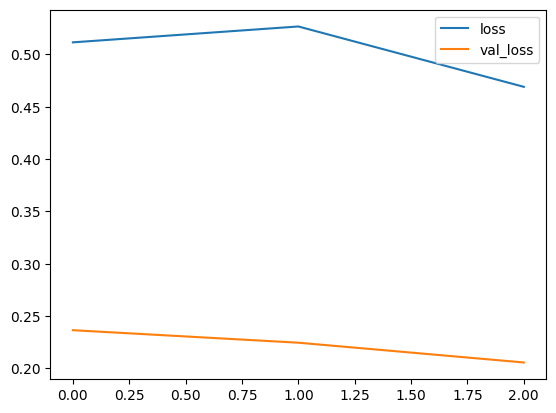

finished linear training
finished linear training
******** Fold 2 ********
^^^^^^^^^^Entrenando con todo el Dataset^^^^^^^^^^
Entrenando sin porcentajes
loaded Contrastive_CB3_Combined model


KeyboardInterrupt: 

In [16]:
args = {
                'subsampling_strategy':{
                    'name': 'subsampling_criteria',
                    'percentage': None
                },
                'optimizer':{
                    'kind': 'Mix_RMSprop',
                    'learning_rate': 1e-6,
                    'momentum': 0.6
                },
                'loss_function': {
                        'kind': 'CombinedLoss',
                        'margin': 0.05,
                        'temperature': 0.07,
                        'mining': {
                            'positives': 'easy',
                            'negatives': 'semihard'
                        }
                },
                'number_folds': 5,
                'backbone_name': 'Contrastive_CB3_Combined',
                'data': 'mertash',
                'sequence_embedding_features': 18432, #Para SPD TS 2080, para solo AC: 18432
                'target_shape': (12, 32, 32),
                'batch_size': 32,
                'epochs': 3,
                    }
run_k_fold(args)

In [ ]:
#Con porcentajes

In [ ]:
for percentage in [40]:
    
    train_data_percentage = percentage / 100
    args = {
                        'subsampling_strategy':{
                            'name': 'subsampling_criteria',
                            'percentage': train_data_percentage
                        },
                        'optimizer':{
                            'kind': 'Mix_RMSprop',
                            'learning_rate': 0.01,
                            'momentum': 0.6
                        },
                        'loss_function': {
                                'kind': 'CombinedLoss',
                                'margin': 0.05,
                                'temperature': 0.07,
                                'mining': {
                                    'positives': 'easy',
                                    'negatives': 'semihard'
                                }
                        },
                        'number_folds': 5,
                        'backbone_name': 'Contrastive_CB3_SPD_1Bire',
                        'data': 'mertash',
                        'sequence_embedding_features': 2080,
                        'target_shape': (12, 32, 32),
                        'batch_size': 32,
                        'epochs': 1500,
                    }
    run_k_fold(args)
    
    

In [ ]:
# for subsampling_criteria in ['stratified', 'reduce_negatives', 'reduce_positives', ]:
#     for percentage in [20, 40, 60, 80, 100]:
#         train_data_percentage = percentage / 100
#         args = {
#                                 'subsampling_strategy':{
#                                     'name': subsampling_criteria,
#                                     'percentage': train_data_percentage
#                                 },
#                                 'optimizer':{
#                                     'kind': 'RMSprop',
#                                     'learning_rate': 1e-6,
#                                     'momentum': 0.6
#                                 },
#                                 'loss_function': {
#                                         'kind': 'NTXentLoss',
#                                         'temperature': 0.07,
#                                         'mining': {
#                                             'positives': None,
#                                             'negatives': None
#                                         }
#                                 },
#                                 'number_folds': 5,
#                                 'backbone_name': 'MertashMultiParametricNetworkV2',
#                                 'data': 'mertash',
#                                 'sequence_embedding_features': 512,
#                                 'target_shape': (12, 32, 32),
#                                 'batch_size': 32,
#                                 'epochs': 5000,
#                             }
#         run_k_fold(args)

# VISUALIZANDO EMBEBIDOS

# CB3()

In [ ]:
 args = {
                        'subsampling_strategy':{
                            'name': 'subsampling_criteria',
                            'percentage': 'train_data_percentage'
                        },
                        'optimizer':{
                            'kind': 'RMSprop',
                            'learning_rate': 1e-6,
                            'momentum': 0.6
                        },
                        'loss_function': {
                                'kind': 'TripletLoss',
                                'temperature': 0.07,
                                'mining': {
                                    'positives': 'easy',
                                    'negatives': 'semihard'
                                }
                        },
                        'number_folds': 5,
                        'backbone_name': 'Contrastive_CB3',
                        'data': 'mertash',
                        'sequence_embedding_features':18432,
                        'target_shape': (12, 32, 32),
                        'batch_size': 32,
                        'epochs': 5000,
                    }

In [ ]:
#'/home/jaolmosr_pupils/Cesar/Experiments/'
# weights_path = '/data/Experiments/models/mertash_contrastive_fold_2.pt'
weights_path = '/data/Experiments_Contrastive_CB3/models/mertash_contrastive_fold_2.pt'
model = Contrastive_CB3(device, args['target_shape'], args['sequence_embedding_features'], 'contrastive')
model.load_state_dict(torch.load(weights_path))


In [ ]:
x_train, x_validation ,y_train, y_validation, ids_train, ids_val = get_fold_of_data(2)

val_data = DatasetManagement(x_validation, y_validation)
train_data = DatasetManagement(x_train, y_train)
test_dataset = val_data

In [ ]:
val_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    shuffle = False,
    batch_size = args['batch_size'],
    pin_memory=False
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Inicializar listas vacías para almacenar las salidas y las etiquetas
all_outputs = []
all_labels = []

with torch.no_grad():
    model.eval()
    model.to(device)
    val_loss = 0.0
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        for j in range(len(inputs)):
            inputs[j] = inputs[j].to(device).type(torch.float)
        labels = labels.to(device)
        outputs = model(inputs)
        outputs = torch.nn.functional.normalize(outputs, p=2.0)
        # Almacenar las salidas y las etiquetas en las listas
        all_outputs.append(outputs.cpu().detach().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenar todas las salidas y las etiquetas
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Aplicar PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(all_outputs)

# Graficar los datos reducidos, coloreando por etiqueta
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=all_labels)
plt.legend(*scatter.legend_elements())
plt.show()

# Imprimir el número de puntos graficados
print(f'Número de puntos graficados: {len(all_outputs)}')




In [ ]:
pca = PCA(n_components=3)  # Inicializar PCA con 3 componentes
reduced = pca.fit_transform(all_outputs)  # Reducir la dimensionalidad de los datos

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar los datos reducidos
scatter = ax.scatter(reduced[:, 0], reduced[:, 1], reduced[:, 2], c=all_labels)

# Definir las leyendas
leyendas = ['maligno', 'benigno']

# Pasar las leyendas al método legend()
plt.legend(handles=scatter.legend_elements()[0], labels=leyendas)

plt.show()


# CB3_SPD

In [ ]:
args = {
        'subsampling_strategy':{
            'name': 'subsampling_criteria',
            'percentage': 'train_data_percentage'
        },
        'optimizer':{
            'kind': 'Mix_RMSprop',
            'learning_rate': 1e-6,
            'momentum': 0.6
        },
        'loss_function': {
                'kind': 'NTXentLoss',
                'temperature': 0.07,
                'mining': {
                    'positives': 'easy',
                    'negatives': 'semihard'
                }
        },
        'number_folds': 5,
        'backbone_name': 'Contrastive_CB3_SPD_1Bire',
        'data': 'mertash',
        'sequence_embedding_features': 136,
        'target_shape': (12, 32, 32),
        'batch_size': 32,
        'epochs': 5000,
    }

In [ ]:
weights_path = '/data/Experiments/models/mertash_contrastive_fold_5.pt'
model = Contrastive_CB3_SPD_1Bire(device, args['target_shape'], args['sequence_embedding_features'], 'contrastive')
model.load_state_dict(torch.load(weights_path))

In [ ]:
x_train, x_validation ,y_train, y_validation, ids_train, ids_val = get_fold_of_data(2)

val_data = DatasetManagement(x_validation, y_validation)
train_data = DatasetManagement(x_train, y_train)
test_dataset = val_data

In [ ]:
val_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    shuffle = False,
    batch_size = args['batch_size'],
    pin_memory=False
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Inicializar listas vacías para almacenar las salidas y las etiquetas
all_outputs = []
all_labels = []

with torch.no_grad():
    model.eval()
    model.to(device)
    val_loss = 0.0
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        for j in range(len(inputs)):
            inputs[j] = inputs[j].to(device).type(torch.float)
        labels = labels.to(device)
        outputs = model(inputs)
        outputs = torch.nn.functional.normalize(outputs, p=2.0)
        # Almacenar las salidas y las etiquetas en las listas
        all_outputs.append(outputs.cpu().detach().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenar todas las salidas y las etiquetas
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Aplicar PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(all_outputs)

# Graficar los datos reducidos, coloreando por etiqueta
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=all_labels)
plt.legend(*scatter.legend_elements())
plt.show()

# Imprimir el número de puntos graficados
print(f'Número de puntos graficados: {len(all_outputs)}')




In [ ]:
pca = PCA(n_components=3)  # Inicializar PCA con 3 componentes
reduced = pca.fit_transform(all_outputs)  # Reducir la dimensionalidad de los datos

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar los datos reducidos
scatter = ax.scatter(reduced[:, 0], reduced[:, 1], reduced[:, 2], c=all_labels, alpha=0.3)

# Definir las leyendas
leyendas = ['maligno', 'benigno']

# Pasar las leyendas al método legend()
plt.legend(handles=scatter.legend_elements()[0], labels=leyendas)

plt.show()
